# Описание проекта

## импорт Библиотек

In [53]:
from ast import literal_eval


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from scipy import stats
from scipy.stats import uniform, randint, loguniform


from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression
)
from sklearn.model_selection import (
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
    train_test_split
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor


from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier


import optuna


from sklearn.metrics import (
    confusion_matrix, 
    ConfusionMatrixDisplay,
    classification_report,
    roc_auc_score, 
    roc_curve
)


import phik
from phik import report


## Импорт Датасетов

In [2]:
apparel_purchases = pd.read_csv("filtered_data/apparel-purchases.csv")

apparel_messages = pd.read_csv("filtered_data/apparel-messages.csv")

target = pd.read_csv("filtered_data/apparel-target_binary.csv")

full_campaign_daily_event = pd.read_csv("filtered_data/full_campaign_daily_event.csv")

full_campaign_daily_event_channel = pd.read_csv("filtered_data/full_campaign_daily_event_channel.csv")

## Информация про apparel_purchases

In [8]:
apparel_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


In [9]:
apparel_purchases["client_id"].nunique()

49849

49849 Уникальных id

In [10]:
apparel_purchases.duplicated().sum()

73020

Есть 73020 дубликатов. Однако мы не можем быть уверены - это настоящие дубликаты или повторяющиеся покупки одного товара


In [11]:
apparel_purchases["quantity"].value_counts()


quantity
1     201323
2        751
3         94
4         12
6          5
10         4
20         3
15         3
5          3
25         2
30         2
9          2
13         1
18         1
8          1
7          1
Name: count, dtype: int64

Видим, что абсолютно большинство записей указывают на покупку одной единицы товара. Будем исходить из того, что единовременная покупка более одной единицы попадает в базу отдельными рядами. К сожалению, остается непроясненным остается, в каких условиях все же будет логироваться более одной единицы

Дубликаты сохраняем в датасете

In [12]:
apparel_purchases.isna().sum()

client_id       0
quantity        0
price           0
category_ids    0
date            0
message_id      0
dtype: int64

Пропущенных значений нет

In [13]:
apparel_purchases["price"].describe()


count    202208.000000
mean       1193.301516
std        1342.252664
min           1.000000
25%         352.000000
50%         987.000000
75%        1699.000000
max       85499.000000
Name: price, dtype: float64

<Axes: xlabel='price', ylabel='Count'>

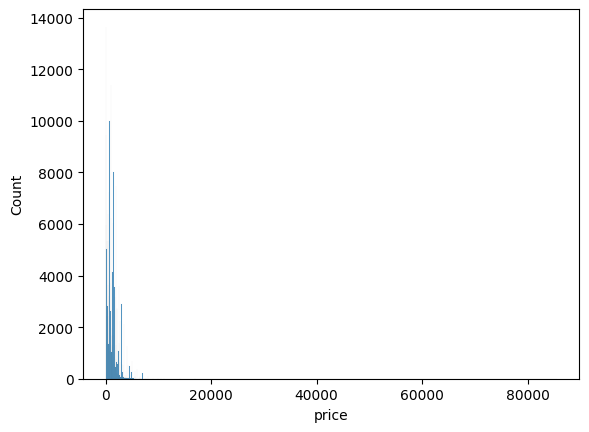

In [14]:
sns.histplot(data = apparel_purchases, x = "price")

Болшая часть наблюдений находится в промежутке между 352 и 1699. Однако распределение очень сильно скошено вправо, из-за редких покупок чья цена заметно выше, чем цена остальных товаров

In [15]:
apparel_purchases["message_id"].nunique()


50204

50204 уникальных значений. Каждый пользователь мог получать более одной рассылки

### Создание агрегированного набора

In [16]:
result = apparel_purchases.groupby("client_id").agg(
    purchase_amount=('client_id', 'size'),
    total_quantity = ('quantity', 'sum'),
    mean_price=('price', 'mean'),
    total_spent=('price', 'sum'),
    unique_dates=('date', 'nunique'),
    latest_date=('date', 'max'),
    first_date = ('date', 'min'))



apparel_purchases_agg = pd.DataFrame(result)

In [17]:
apparel_purchases_agg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49849 entries, 1515915625468060902 to 1515915626010443624
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   purchase_amount  49849 non-null  int64  
 1   total_quantity   49849 non-null  int64  
 2   mean_price       49849 non-null  float64
 3   total_spent      49849 non-null  float64
 4   unique_dates     49849 non-null  int64  
 5   latest_date      49849 non-null  object 
 6   first_date       49849 non-null  object 
dtypes: float64(2), int64(3), object(2)
memory usage: 3.0+ MB


### Преобразование category_ids

In [18]:
def aggregate_categories(df):
    # Проверяем наличие необходимых колонок
    if 'client_id' not in df.columns or 'category_ids' not in df.columns:
        raise ValueError("DataFrame должен содержать колонки 'client_id' и 'category_ids'")
    
    def combine_categories(x):
        try:
            # Проверяем, что x не пустой
            if x.empty:
                return []
                
            # Преобразуем все значения в списки, если они еще не являются списками
            all_items = []
            for sublist in x:
                if isinstance(sublist, str):
                    # Если значение является строкой, пробуем его преобразовать
                    try:
                        sublist = eval(sublist)
                    except:
                        continue
                if isinstance(sublist, list):
                    all_items.extend([item for item in sublist if item is not None])
                elif sublist is not None:
                    all_items.append(sublist)
            
            # Возвращаем уникальные отсортированные значения
            return sorted(list(set(all_items)))
        except Exception as e:
            print(f"Ошибка при обработке данных: {e}")
            return []
    
    try:
        result = df.groupby('client_id').agg({
            'category_ids': combine_categories
        }).reset_index()
        
        return result
    except Exception as e:
        print(f"Ошибка при группировке данных: {e}")
        return None

result_df = aggregate_categories(apparel_purchases)

In [19]:
# Создаем функцию для преобразования списков категорий в one-hot-encoding
def categories_to_one_hot(df):
    # Разворачиваем список категорий в столбцы (используем 1 для обозначения наличия категории)
    one_hot = pd.get_dummies(df['category_ids'].explode(), prefix='category')
    
    # Группируем обратно по индексу (client_id), используя максимальное значение
    # чтобы получить 1, если категория была хотя бы раз
    one_hot = one_hot.groupby(level=0).max()
    
    # Объединяем с исходным датафреймом
    result = pd.concat([df.drop('category_ids', axis=1), one_hot], axis=1)
    
    return result

# Применяем преобразование к нашему result_df
result_one_hot = categories_to_one_hot(result_df)

In [20]:
result_one_hot = result_one_hot.astype({col: 'int8' for col in result_one_hot.columns if col != 'client_id'})


# Вычисляем процент единиц в каждой колонке categories
# Берём только колонки, начинающиеся с 'category_'
category_columns = result_one_hot.filter(like='category_').columns
column_percentages = result_one_hot[category_columns].mean()

# Отбираем колонки, где процент единиц больше 30% (0.3)
columns_to_keep = column_percentages[column_percentages > 0.02].index

# Формируем финальный датафрейм
# Сохраняем client_id и отфильтрованные category колонки
category_df = result_one_hot[['client_id'] + list(columns_to_keep)]

In [21]:
apparel_purchases_agg = apparel_purchases_agg.merge(category_df, on="client_id", how = "left")

In [22]:
# 1. Конвертируем даты более эффективно одной операцией
date_columns = ['latest_date', 'first_date']
apparel_purchases_agg[date_columns] = apparel_purchases_agg[date_columns].apply(pd.to_datetime)

# 2. Получаем общие границы времени
overall_latest_date = pd.to_datetime(apparel_purchases['date']).max()
overall_first_date = pd.to_datetime(apparel_purchases['date']).min()

# 3. Считаем основные временные метрики
apparel_purchases_agg = apparel_purchases_agg.assign(
    # Recency (сколько дней прошло с последней покупки)
    days_since_last_purchase=(overall_latest_date - apparel_purchases_agg['latest_date']).dt.days,
    # Насколько давно клиент с нами
    # Активный период клиента
    customer_lifetime=(apparel_purchases_agg['latest_date'] - apparel_purchases_agg['first_date']).dt.days
)


## Кластеризация рассылок

In [23]:
full_campaign_agg = full_campaign_daily_event.groupby("bulk_campaign_id").agg(
    campaign_duration = ('date', 'nunique'),
    campaign_send = ("count_send", "sum"),
    campaign_clicks = ("count_click", "sum"),
    campaign_complain = ("count_complain", "sum"),
    campaign_hard_bounce = ("count_hard_bounce", "sum"),
    campaign_open = ("count_open", "sum"),
    campaign_purchase = ("count_purchase", "sum"),
    campaign_soft_bounce = ("count_soft_bounce", "sum"),
    campaign_subscribe = ("count_subscribe", "sum"),
    campaign_unsubscribe = ("count_unsubscribe", "sum")
)


columns_to_normalize = ["campaign_clicks", "campaign_complain", 
                       "campaign_open", "campaign_purchase",  
                        "campaign_unsubscribe"]
norming_column = "campaign_duration"

for column in columns_to_normalize:
    full_campaign_agg[column] = full_campaign_agg[column] / full_campaign_agg[norming_column]

full_campaign_agg = full_campaign_agg.reset_index()

In [25]:
# Create scaler object 
scaler = StandardScaler()

# Select features for clustering
clustering_features = ["campaign_clicks", "campaign_complain", 
                       "campaign_open", "campaign_purchase",  
                        "campaign_unsubscribe"]
full_campaign_agg_cluster_data = full_campaign_agg[clustering_features]

# Scale the features
scaled_data = scaler.fit_transform(full_campaign_agg_cluster_data)

# Initialize and fit KMeans
N_CLUST = 10

kmeans = KMeans(n_clusters=N_CLUST, random_state=42)
kmeans.fit(scaled_data)

# Add cluster labels to original DataFrame
full_campaign_agg['cluster'] = kmeans.labels_

# Create binary columns for each cluster
for i in range(N_CLUST):
   full_campaign_agg[f'cluster_{i+1}'] = (full_campaign_agg['cluster'] == i).astype(int)

# Drop the original cluster column if you don't need it

## Изучение apparel_messages

In [35]:
apparel_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


In [36]:
apparel_messages["bulk_campaign_id"].nunique()

2709

Всего было 2709 уникальных рассылки. ВЕроятность возвращения клиента может зависеть от "качества" рассылки, поэтому нужно будет учесть этот параметр, сократив количество комбинаций

In [37]:
apparel_messages["client_id"].nunique()

53329

In [38]:
# Преобразуем столбцы client_id в множества
messages_clients = set(apparel_messages['client_id'])
purchases_clients = set(apparel_purchases['client_id'])

# Находим общие значения (пересечение множеств)
common_clients = messages_clients.intersection(purchases_clients)

# Находим уникальные значения для каждого датасета
only_messages = messages_clients - purchases_clients
only_purchases = purchases_clients - messages_clients

# Выводим результаты
print(f"Общих client_id: {len(common_clients)}")
print(f"Уникальных client_id только в messages: {len(only_messages)}")
print(f"Уникальных client_id только в purchases: {len(only_purchases)}")

Общих client_id: 41982
Уникальных client_id только в messages: 11347
Уникальных client_id только в purchases: 7867


Количество уникальных клиентов отличается от датасета с покупками и таргетом. Таких пользователей мы уберем при слиянии датасетов. Помимо этого есть пользователи, которые могли делать покупки, но у нас нет данных о получаемых ими рассылках. Таких пользователей мы в анализе сохраним и присвоим ими нули.

In [39]:
apparel_messages["event"].value_counts()

event
send           9058196
open           3085820
click           496339
purchase         64679
hard_bounce      19903
soft_bounce      10583
unsubscribe       2841
hbq_spam           823
complain           528
subscribe           85
close                1
Name: count, dtype: int64

Видим, что по обобщенным данным логичная воронка. Количество значений снижается от общего события (отправка писем) к следующим события (открытое письмо, клик на письмо и покупка). Также часто встречаются ошибки отправки. Наиболее редки, но при этом скорее всего очень показатель - негативные события - отписка от рассылка, перемещение в спам

In [40]:
apparel_messages["channel"].value_counts()

channel
mobile_push    7512156
email          5227642
Name: count, dtype: int64

Используются два канала - mobile_push и email. mobile_push чаще


In [41]:
(apparel_messages.groupby("channel")["event"].value_counts(normalize=True) * 100).round(2)


channel      event      
email        send           75.32
             open           16.73
             click           6.81
             purchase        0.87
             soft_bounce     0.18
             unsubscribe     0.05
             hbq_spam        0.02
             complain        0.01
             hard_bounce     0.01
             subscribe       0.00
mobile_push  send           68.17
             open           29.43
             click           1.86
             hard_bounce     0.26
             purchase        0.26
             soft_bounce     0.01
             close           0.00
Name: proportion, dtype: float64

Видим, что открывают чаще мобильные пуши, но до покупок чаще доходят именно почтовые рассылки

In [42]:
apparel_messages["date"].head()

0    2022-05-19
1    2022-05-19
2    2022-05-19
3    2022-05-19
4    2022-05-19
Name: date, dtype: object

In [ ]:
apparel_messages["created_at"].head()

Видим, что для рассылок есть полное время. Это позволит выявить полные дубликаты 


In [43]:
apparel_messages.duplicated().sum()

48610

Видим, что есть 48610 полных дубликатов. Удаляем их.
В реальности нужно было бы уточнить их природу - это ошибка логов, или ошибка рассылки (пользователь действительно получал дважды одинаковое сообщение)

In [44]:
apparel_messages = apparel_messages.drop_duplicates(keep='first')


In [45]:
apparel_messages = apparel_messages.merge(full_campaign_agg, on = "bulk_campaign_id", how = "left" )

In [46]:
apparel_messages_agg = apparel_messages.groupby("client_id").agg(
    # Event counts
    click_count=('event', lambda x: (x == 'click').sum()),
    purchase_count=('event', lambda x: (x == 'purchase').sum()),
    send_count=('event', lambda x: (x == 'send').sum()),
    open_count=('event', lambda x: (x == 'open').sum()),
    hard_bounce_count=('event', lambda x: (x == 'hard_bounce').sum()),
    unsubscribe_count=('event', lambda x: (x == 'unsubscribe').sum()),
    complain_count=('event', lambda x: (x == 'complain').sum()),
    subscribe_count=('event', lambda x: (x == 'subscribe').sum()),
    # Channel counts (keeping these the same)
    email_count=('channel', lambda x: (x == 'email').sum()),
    mobile_push_count=('channel', lambda x: (x == 'mobile_push').sum()),
    in_cluster_1=('cluster_1', 'max'),
    in_cluster_2=('cluster_2', 'max'),
    in_cluster_3=('cluster_3', 'max'),
    in_cluster_4=('cluster_4', 'max'),
    in_cluster_5=('cluster_5', 'max'),
    in_cluster_6=('cluster_6', 'max'),
    in_cluster_7=('cluster_7', 'max'),
    in_cluster_8=('cluster_8', 'max'),
    in_cluster_9=('cluster_9', 'max'),
    in_cluster_10=('cluster_10', 'max')
)

# Create the DataFrame
apparel_messages_agg = pd.DataFrame(apparel_messages_agg)

## Финализируем Датасет

In [47]:
final_df = apparel_purchases_agg.merge(apparel_messages_agg, on = "client_id", how = "left").merge(target, on="client_id")

In [48]:
missing_counts = final_df.isna().sum()
missing_counts = missing_counts[missing_counts > 0]
missing_counts

click_count          7867
purchase_count       7867
send_count           7867
open_count           7867
hard_bounce_count    7867
unsubscribe_count    7867
complain_count       7867
subscribe_count      7867
email_count          7867
mobile_push_count    7867
in_cluster_1         7867
in_cluster_2         7867
in_cluster_3         7867
in_cluster_4         7867
in_cluster_5         7867
in_cluster_6         7867
in_cluster_7         7867
in_cluster_8         7867
in_cluster_9         7867
in_cluster_10        7867
dtype: int64

In [49]:
final_df = final_df.fillna(0)

### eda

In [54]:
columns_to_check = [col for col in final_df.columns if col not in ['client_id', 'target']]
phik_coefficients = {}

# Собираем коэффициенты для каждой колонки
for column in columns_to_check:
    try:
        result = phik.phik_matrix(final_df[[column, "target"]])
        # Если матрица неполная, считаем корреляцию нулевой
        if result.shape != (2, 2):
            phik_coefficients[column] = 0.0
        else:
            phik_coefficients[column] = result.values[0,1]
    except Exception as e:
        print(f"Warning: Error processing {column}, setting correlation to 0")
        phik_coefficients[column] = 0.0

# Создаем DataFrame
phik_df = pd.DataFrame.from_dict(phik_coefficients, orient='index', columns=['phik_coefficient'])
phik_df = phik_df.sort_values('phik_coefficient', ascending=False)



interval columns not set, guessing: ['purchase_amount', 'target']
interval columns not set, guessing: ['total_quantity', 'target']
interval columns not set, guessing: ['mean_price', 'target']
interval columns not set, guessing: ['total_spent', 'target']
interval columns not set, guessing: ['unique_dates', 'target']
interval columns not set, guessing: ['target']
interval columns not set, guessing: ['target']
interval columns not set, guessing: ['category_124', 'target']
interval columns not set, guessing: ['category_146', 'target']
interval columns not set, guessing: ['category_17', 'target']
interval columns not set, guessing: ['category_18', 'target']
interval columns not set, guessing: ['category_2', 'target']
interval columns not set, guessing: ['category_212', 'target']
interval columns not set, guessing: ['category_213', 'target']
interval columns not set, guessing: ['category_218', 'target']
interval columns not set, guessing: ['category_244', 'target']
interval columns not set, 

c:\Users\baxte\Dropbox\Masterskaya_2\.venv\Lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable in_cluster_3 for analysis 1. Dropping this column
  warnings.warn(
c:\Users\baxte\Dropbox\Masterskaya_2\.venv\Lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable in_cluster_8 for analysis 1. Dropping this column
  warnings.warn(


interval columns not set, guessing: ['in_cluster_7', 'target']
interval columns not set, guessing: ['in_cluster_8', 'target']
interval columns not set, guessing: ['in_cluster_9', 'target']
interval columns not set, guessing: ['in_cluster_10', 'target']


In [57]:
print("\nTop 10 features by Phik correlation:")
print(phik_df.head(20))


Top 10 features by Phik correlation:
                          phik_coefficient
latest_date                       0.163991
customer_lifetime                 0.134146
first_date                        0.123334
days_since_last_purchase          0.115966
unique_dates                      0.074335
click_count                       0.070769
purchase_count                    0.069807
purchase_amount                   0.067004
mobile_push_count                 0.064416
open_count                        0.057812
send_count                        0.056721
total_quantity                    0.049839
category_27                       0.046442
category_436                      0.045507
in_cluster_1                      0.043173
in_cluster_6                      0.041834
category_6060                     0.039587
category_213                      0.039547
in_cluster_7                      0.039517
total_spent                       0.034520


Видим, что больше всего связан с вероятностью покупки такие переменные как

customer_lifetime
days_since_last_purchase
unique_dates
click_count
purchase_count
purchase_amount
Mobile_push_count
open_count

И что интересно - отдельные категории и даже кластеры оказались среди значимых предикторов

### Моделирование

In [58]:
X = final_df.drop(["target", "client_id", 'latest_date', 'first_date'], axis = 1)
y = final_df["target"]

In [59]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, 
    test_size=0.2,
    stratify=y,            # Add this parameter
    random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,
    stratify=y_temp,       # Add this parameter
    random_state=42
)

In [60]:
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()


num_cols = ["purchase_amount", "total_quantity", "mean_price", "total_spent",
"unique_dates", "days_since_last_purchase", "customer_lifetime", "click_count",
"purchase_count", "send_count", "open_count", "hard_bounce_count", "unsubscribe_count",
"complain_count", "subscribe_count", "email_count", "mobile_push_count"]

```

def create_pipeline(trial, classifier_name):
    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy=trial.suggest_categorical('num_imputer_strategy', ['mean', 'median']))),
        ('scaler', StandardScaler())
    ])
    
    cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(drop='first', sparse_output=False))
    ])
    
    preprocessor = ColumnTransformer([
        ('num', num_pipeline, num_cols),
        ('cat', cat_pipeline, cat_cols)
    ], remainder='passthrough')
    
    if classifier_name == 'logistic':
        classifier = LogisticRegression(
            C=trial.suggest_float('lr_C', 1e-3, 10, log=True),
            max_iter=trial.suggest_int('lr_max_iter', 100, 500),
            random_state=42
        )
    elif classifier_name == 'decision_tree':
        classifier = DecisionTreeClassifier(
            max_depth=trial.suggest_int('dt_max_depth', 3, 15),
            min_samples_split=trial.suggest_int('dt_min_samples_split', 2, 20),
            min_samples_leaf=trial.suggest_int('dt_min_samples_leaf', 1, 10),
            random_state=42
        )
    elif classifier_name == 'lgbm':
        classifier = LGBMClassifier(
            n_estimators=trial.suggest_int('lgbm_n_estimators', 50, 300),
            learning_rate=trial.suggest_float('lgbm_learning_rate', 0.01, 0.3, log=True),
            num_leaves=trial.suggest_int('lgbm_num_leaves', 15, 127),
            min_child_samples=trial.suggest_int('lgbm_min_child_samples', 5, 100),
            subsample=trial.suggest_float('lgbm_subsample', 0.5, 1.0),
            colsample_bytree=trial.suggest_float('lgbm_colsample_bytree', 0.5, 1.0),
            random_state=42
        )
    elif classifier_name == 'catboost':
        classifier = CatBoostClassifier(
            iterations=trial.suggest_int('cb_iterations', 50, 500),
            learning_rate=trial.suggest_float('cb_learning_rate', 0.001, 0.1, log=True),
            depth=trial.suggest_int('cb_depth', 3, 12),
            l2_leaf_reg=trial.suggest_float('cb_l2_leaf_reg', 1, 30),
            random_strength=trial.suggest_float('cb_random_strength', 1e-3, 20, log=True),
            min_data_in_leaf=trial.suggest_int('cb_min_data_in_leaf', 1, 50),
            auto_class_weights=trial.suggest_categorical('cb_class_weights', [None, 'Balanced', 'SqrtBalanced']),
            subsample=trial.suggest_float('cb_subsample', 
            0.5, 1.0),  # Добавил для баггинга
            leaf_estimation_iterations=trial.suggest_int('cb_leaf_estimation_iterations', 
            1, 10),  # Добавил для точности оценки листьев
            random_state=42,
            verbose=False
        )
    
    return Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

def objective(trial, X, y, classifier_name):
    pipeline = create_pipeline(trial, classifier_name)
    
    # Perform cross-validation
    scores = cross_val_score(
        pipeline, X, y,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1
    )
    
    return scores.mean()

# Create separate studies for each classifier
#classifiers = ['logistic', 'decision_tree', 'lgbm', 'catboost']
classifiers = ['catboost']
#classifiers = ['lgbm']
studies = {}

for classifier in classifiers:
    study = optuna.create_study(
        direction='maximize',
        study_name=f'{classifier}_optimization',
        sampler=optuna.samplers.TPESampler(seed=42)
    )
    
    # Optimize each classifier
    study.optimize(
        lambda trial: objective(trial, X_train, y_train, classifier),
        n_trials=50,  # Adjust based on your computational budget
        n_jobs=1,  # Use 1 for CatBoost, -1 for others
        show_progress_bar=True
    )
    
    studies[classifier] = study

# Get best results for each classifier
best_results = {}
for classifier, study in studies.items():
    best_results[classifier] = {
        'best_score': study.best_value,
        'best_params': study.best_params
    }
    print(f"\nBest {classifier} Results:")
    print(f"Score: {study.best_value:.4f}")
    print("Parameters:", study.best_params)

best_classifier = max(best_results.items(), key=lambda x: x[1]['best_score'])[0]

final_pipeline = create_pipeline(
    optuna.trial.FixedTrial(best_results[best_classifier]['best_params']),
    best_classifier
)

```

In [61]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # используем median из оптимальных параметров
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
], remainder='passthrough')

# Создаем CatBoost с оптимальными параметрами
catboost_classifier = CatBoostClassifier(
    iterations=308,
    learning_rate=0.030595276962024773,
    depth=3,
    l2_leaf_reg=6.394738594560913,
    random_strength=0.9803777223919052,
    min_data_in_leaf=38,
    auto_class_weights='SqrtBalanced',
    subsample=0.6594952902213623,
    leaf_estimation_iterations=8,
    random_state=42,
    verbose=False
)

# Создаем финальный пайплайн
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', catboost_classifier)
])

In [62]:
final_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['purchase_amount',
                                                   'total_quantity',
                                                   'mean_price', 'total_spent',
                                                   'unique_dates',
                                                   'days_since_last_purchase',
                                                   'customer_lifetime',
                                                   'click_count',
                                                   'purchase_count',
                                                   'send_co...t',
                                                   'hard_bounce_count',
                                                   'unsubscribe_count',
                                                   'complain_count',
                                                   'subscribe_count',
                                                   'email_count',
                                                   'mobile_push_count']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  [])])),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x000001604D8ED390>)])

In [ ]:
###  Feature Importance

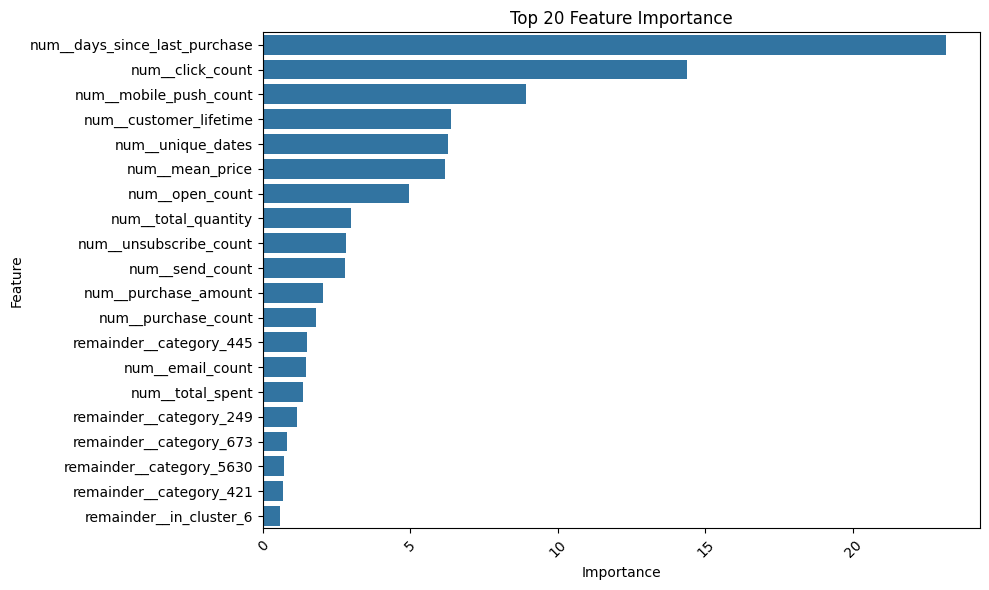

In [63]:
# Получаем модель CatBoost из пайплайна
catboost_model = final_pipeline.named_steps['classifier']

# 1. Получение Feature Importance по умолчанию (PredictionValuesChange)
feature_importance = catboost_model.get_feature_importance()
feature_names = final_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Создаем DataFrame с важностью признаков
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})
importance_df = importance_df.sort_values('Importance', ascending=False)

# Визуализация
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(20), x='Importance', y='Feature')
plt.title('Top 20 Feature Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# результат на трейне

In [64]:
y_pred = final_pipeline.predict(X_train)
y_proba = final_pipeline.predict_proba(X_train)
y_proba_positive = final_pipeline.predict_proba(X_train)[:, 1]

probs_df = pd.DataFrame({
    'true_label': y_train,
    'predicted_prob': y_proba_positive
})




# Установка порога (например, 0.7)
#threshold = 0.1

# Получение предсказаний с новым порогом
#y_pred = (y_proba_positive >= threshold).astype(int)

AUC Score: 0.778

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     29332
           1       0.33      0.10      0.16       577

    accuracy                           0.98     29909
   macro avg       0.66      0.55      0.57     29909
weighted avg       0.97      0.98      0.97     29909



<Figure size 1000x800 with 0 Axes>

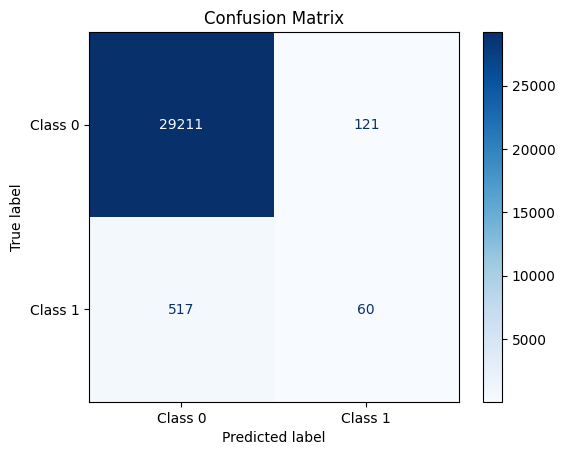

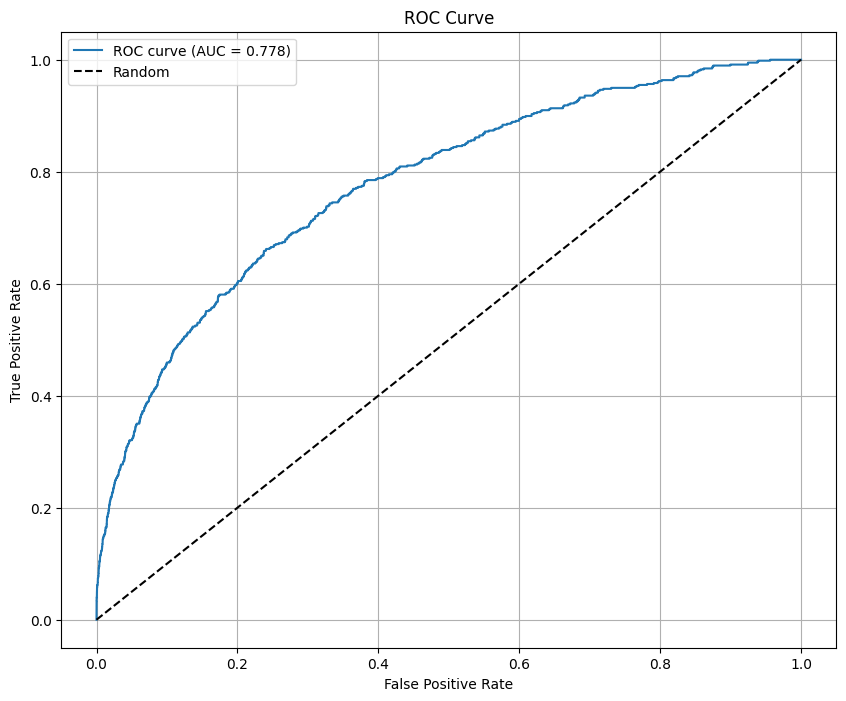

In [65]:
# Calculate metrics
auc_score = roc_auc_score(y_train, y_proba_positive)
conf_matrix = confusion_matrix(y_train, y_pred)

# Print classification report and AUC
print(f'AUC Score: {auc_score:.3f}\n')
print('Classification Report:')
print(classification_report(y_train, y_pred))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix,
    display_labels=['Class 0', 'Class 1']
).plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)

# Plot ROC curve
plt.figure(figsize=(10, 8))
fpr, tpr, _ = roc_curve(y_train, y_proba_positive)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

## результат на валидации

In [66]:
y_pred = final_pipeline.predict(X_val)
y_proba = final_pipeline.predict_proba(X_val)
y_proba_positive = final_pipeline.predict_proba(X_val)[:, 1]

AUC Score: 0.770

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      9778
           1       0.23      0.06      0.10       192

    accuracy                           0.98      9970
   macro avg       0.60      0.53      0.54      9970
weighted avg       0.97      0.98      0.97      9970



<Figure size 1000x800 with 0 Axes>

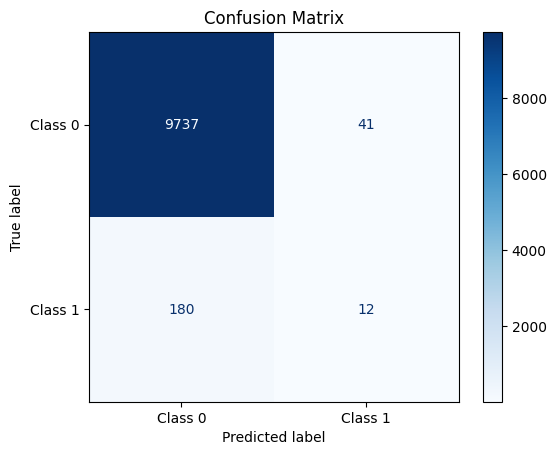

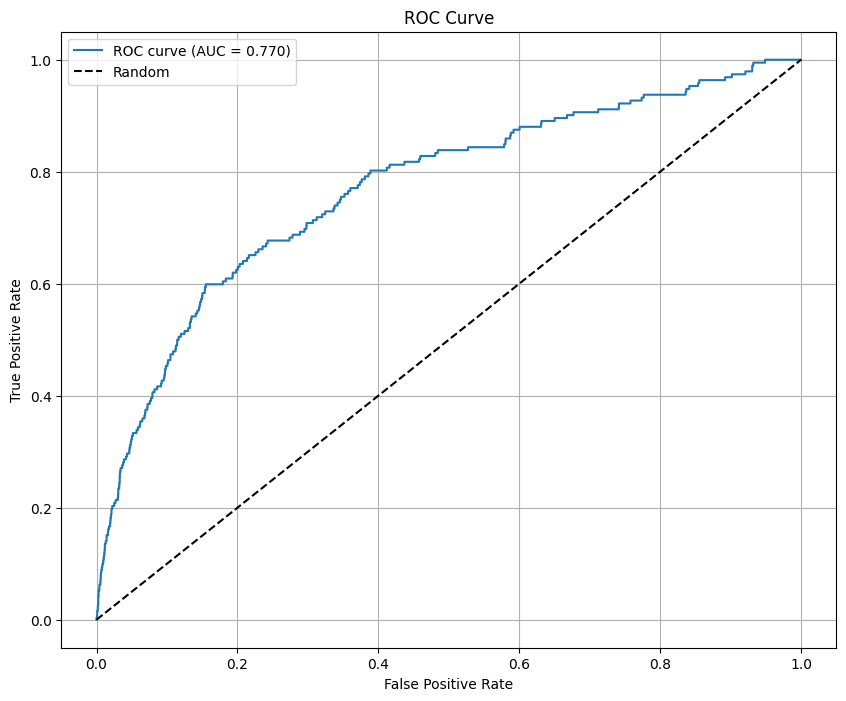

In [67]:
# Calculate metrics
auc_score = roc_auc_score(y_val, y_proba_positive)
conf_matrix = confusion_matrix(y_val, y_pred)

# Print classification report and AUC
print(f'AUC Score: {auc_score:.3f}\n')
print('Classification Report:')
print(classification_report(y_val, y_pred))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix,
    display_labels=['Class 0', 'Class 1']
).plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)

# Plot ROC curve
plt.figure(figsize=(10, 8))
fpr, tpr, _ = roc_curve(y_val, y_proba_positive)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

# Результат на тестовой выборке

In [69]:
y_pred = final_pipeline.predict(X_test)
y_proba = final_pipeline.predict_proba(X_test)
y_proba_positive = final_pipeline.predict_proba(X_test)[:, 1]

AUC Score: 0.760

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      9778
           1       0.18      0.04      0.07       192

    accuracy                           0.98      9970
   macro avg       0.58      0.52      0.53      9970
weighted avg       0.97      0.98      0.97      9970



<Figure size 1000x800 with 0 Axes>

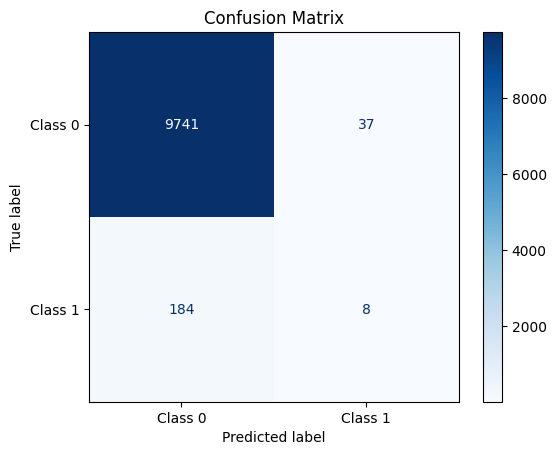

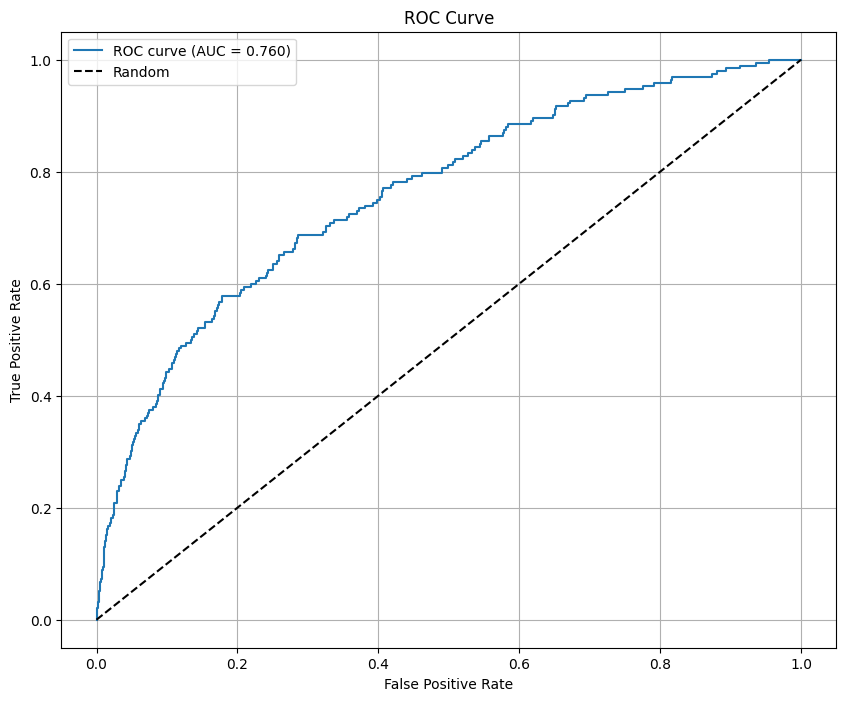

In [70]:
# Calculate metrics
auc_score = roc_auc_score(y_test, y_proba_positive)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print classification report and AUC
print(f'AUC Score: {auc_score:.3f}\n')
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix,
    display_labels=['Class 0', 'Class 1']
).plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)

# Plot ROC curve
plt.figure(figsize=(10, 8))
fpr, tpr, _ = roc_curve(y_test, y_proba_positive)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()